## smFISH validation of astrocytes in the mouse brain

!pip install opencv-python
!pip install dask_image --upgrade
!pip install scikit-image --upgrade
!pip install imageio --upgrade

In [1]:
import glob
from dask_image.imread import imread
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#import cell2location

import sys
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

In [2]:
# Load quantified data from segmentation maps
path_measurement = '/nfs/team283_imaging/VK_C2L/playground_Tong/ilastik/measurements_filtered/'

slide_id = 'VK_C2L_O14S_DAHN58.1d_Nucleus_Lgr6_Agt_Chl1_Angpt1_Meas1b_A1_F1T0'

angpt1_file = f'{slide_id}.ome_Alexa_647.csv'
lgr6_file = f'{slide_id}.ome_Alexa_488.csv'
agt_file = f'{slide_id}.ome_Alexa_568.csv'

agt = pd.read_csv(f'{path_measurement}{agt_file}', index_col='label')
angpt1 = pd.read_csv(f'{path_measurement}{angpt1_file}', index_col='label')
lgr6 = pd.read_csv(f'{path_measurement}{lgr6_file}', index_col='label')

In [3]:
agt['mean_intensity'].describe(), angpt1['mean_intensity'].describe(), lgr6['mean_intensity'].describe()

(count    9661.000000
 mean     1048.663603
 std       421.763587
 min       510.404977
 25%       715.440917
 50%       937.995305
 75%      1286.320938
 max      4513.081377
 Name: mean_intensity, dtype: float64,
 count    9661.000000
 mean      168.447877
 std        41.898834
 min       122.871595
 25%       144.971429
 50%       156.892946
 75%       176.800866
 max       849.375000
 Name: mean_intensity, dtype: float64,
 count    9661.000000
 mean      146.230978
 std        13.501420
 min       114.478125
 25%       136.815217
 50%       144.496000
 75%       153.563743
 max       225.911914
 Name: mean_intensity, dtype: float64)

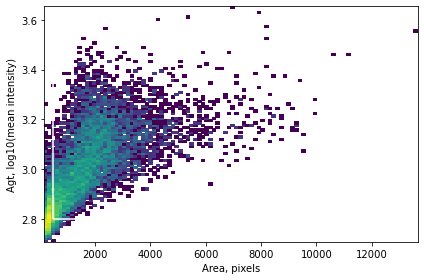

In [4]:
plt.hist2d(agt['area'].values, np.log10(agt['mean_intensity'].values), 
           bins = 100, norm=matplotlib.colors.LogNorm());
plt.xlabel('Area, pixels');
plt.ylabel('Agt, log10(mean intensity)');
plt.title('');
plt.tight_layout();
plt.hlines(2.8, 500, 7000, color='white');
plt.vlines(500, 2.8, 3.7, color='white');

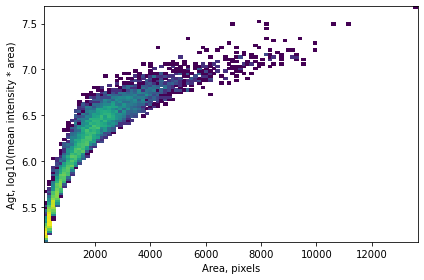

In [5]:
plt.hist2d(agt['area'].values, np.log10(agt['mean_intensity'].values * agt['area'].values), 
           bins = 100, norm=matplotlib.colors.LogNorm());
plt.xlabel('Area, pixels');
plt.ylabel('Agt, log10(mean intensity * area)');
plt.title('');
plt.tight_layout();
plt.hlines(2.8, 500, 7000, color='white');
plt.vlines(500, 2.8, 3.7, color='white');

In [6]:
#agt = agt.loc[np.array(agt['area'] > 500) & np.array(np.log10(agt['mean_intensity'].values) > 2.8),:]
#angpt1_all = angpt1.copy()
#angpt1 = angpt1.loc[agt.index,:]
#lgr6 = lgr6.loc[agt.index,:]
#agt.to_csv(f'{path_measurement}filtered{agt_file}')

## Load raw images

In [7]:
# Load image data
paths_glob = ["/nfs/team283_imaging/0HarmonyStitched/VK_C2L/200917_182515-V__2020-09-17T18_38_24-Measurement 1b/",
    "/nfs/team283_imaging/0HarmonyStitched/JSP_HSS/200924_202612-V__2020-09-24T20_53_38-Measurement 1b/",
    "/nfs/team283_imaging/0HarmonyStitched/JSP_HSS/200924_221940-V__2020-09-24T22_46_54-Measurement 1b/"]
paths = glob.glob(f'{paths_glob[1]}*.ome.tif')

imgs = imread(f'{paths_glob[1]}{slide_id}.ome.tif')

In [8]:
paths

['/nfs/team283_imaging/0HarmonyStitched/JSP_HSS/200924_202612-V__2020-09-24T20_53_38-Measurement 1b/VK_C2L_O14S_DAHN58.1d_Nucleus_Lgr6_Agt_Chl1_Angpt1_Meas1b_A1_F3T0.ome.tif',
 '/nfs/team283_imaging/0HarmonyStitched/JSP_HSS/200924_202612-V__2020-09-24T20_53_38-Measurement 1b/VK_C2L_O14S_DAHN58.1d_Nucleus_Lgr6_Agt_Chl1_Angpt1_Meas1b_A1_F2T0.ome.tif',
 '/nfs/team283_imaging/0HarmonyStitched/JSP_HSS/200924_202612-V__2020-09-24T20_53_38-Measurement 1b/VK_C2L_O14S_DAHN58.1d_Nucleus_Lgr6_Agt_Chl1_Angpt1_Meas1b_A1_F1T0.ome.tif']

## Load segmentation masks

In [9]:
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import tifffile #pip install tifffile

def color_tiff(img):
    img = img%60
    seg_color = np.zeros((*img.shape, 3), dtype=np.uint8)
    for i in tqdm(range(1, img.max()+1)):
        seg_color[img==i] = np.random.randint(0, 255, 3)
    return seg_color

masks_path = '/nfs/team283_imaging/VK_C2L/playground_Tong/ilastik/blurred_2_iter_closing/'
my_masks_path = '/nfs/team283_imaging/VK_C2L/playground_vitalii/masks/'

In [12]:
!ls /nfs/team283_imaging/VK_C2L/playground_Tong/ilastik/

AGT		       obj_agt_classification.ilp	round1.tif
AGT_blurred	       obj_predict			round2_weaker.tif
filtered_raw	       pixel_agt_only_less_blurred	thalamus_astrocyte_mask
measurements_filtered  pixel_agt_only_less_blurred.ilp	thalamus_masks


segm_img = tifffile.imread(f'{masks_path}{slide_id}.ome_mask_agt_closed_2.tif')
colored_segm_img = color_tiff(segm_img)
#plt.imshow(colored_segm_img)
#plt.show()

In [13]:
def prepare_image(imgs, colored_segm_img=None, layer_num=0, alpha=0.5, 
                  resize_factor=None, rescale_intensities=(150, 500)):

    img_layer = imgs[layer_num].compute()

    # Get the color map by name:
    cm = plt.get_cmap('Greys_r')

    if colored_segm_img is not None:
        
        img_layer = np.clip(img_layer, rescale_intensities[0], rescale_intensities[1]) # rescale intensities
        img_layer -= img_layer.min()
        
        # Apply the colormap like a function to any array:
        img_layer = cm(img_layer)[:, :, :3] * 255
        
        binary_mask = np.zeros_like(img_layer)
        for i in range(img_layer.shape[2]):
            binary_mask[:, :, i] = segm_img > 0
        img_layer = img_layer * (1 - binary_mask) \
        + img_layer * binary_mask * alpha \
        + colored_segm_img * (1 - alpha)
    
    if resize_factor is not None:
        
        new_dim = (np.array(img_layer.shape)[::-1] * resize_factor).astype(int)
        img_layer = cv.resize(img_layer, (new_dim[0], new_dim[1]))
        
    if colored_segm_img is None:
        
        img_layer = np.clip(img_layer, rescale_intensities[0], rescale_intensities[1]) # rescale intensities
        img_layer = img_layer - img_layer.min()
        
        # Apply the colormap like a function to any array:
        img_layer = cm(img_layer)[:, :, :3] * 255
    
    return img_layer.astype(int)

### Full brain maps with background

In [15]:
from cell2location.plt.mapping_video import plot_spatial

resize_factor = 1 / 10

img_layer_small = prepare_image(imgs, colored_segm_img=None, 
                                layer_num=0, alpha=0.5, 
                                resize_factor=resize_factor,
                                rescale_intensities=(150, 500))

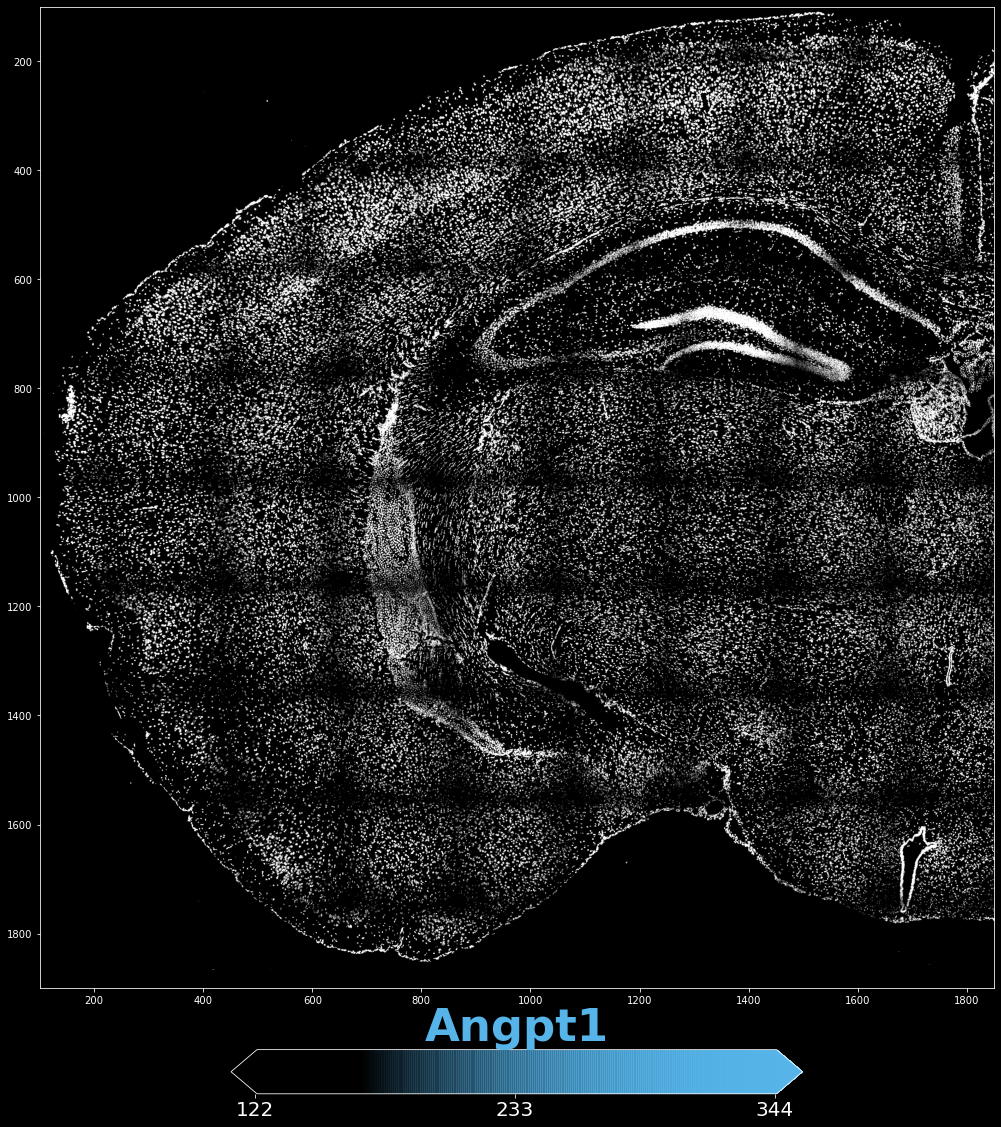

In [22]:
# Angpt1 in astros with Agt background
with matplotlib.rc_context({'axes.facecolor':  'white',
                            "figure.figsize": [20,20]}):
    fig = plot_spatial(angpt1[['mean_intensity']], labels=['Angpt1'],
                  coords=angpt1[['centroid-1', 'centroid-0']].values * resize_factor, 
                  img=img_layer_small, show_img=True, img_alpha=1,
                  circle_diameter=3, alpha_scaling=0, reorder_cmap=[2, 0, 1],
                  plt_axis='on', style='dark_background',
                  max_color_quantile=0.99, image_cmap='Greys_r',
                  crop_x=[100, 1850], crop_y=[100, 1900], axis_y_flipped=True,
                     colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                     colorbar_shape={'vertical_gaps': 0.12, 'horizontal_gaps': 1, 
                                     'width': 3.5, 'height': 0.045},
                     colorbar_tick_size=20)

### Full brain maps WITHOUT background

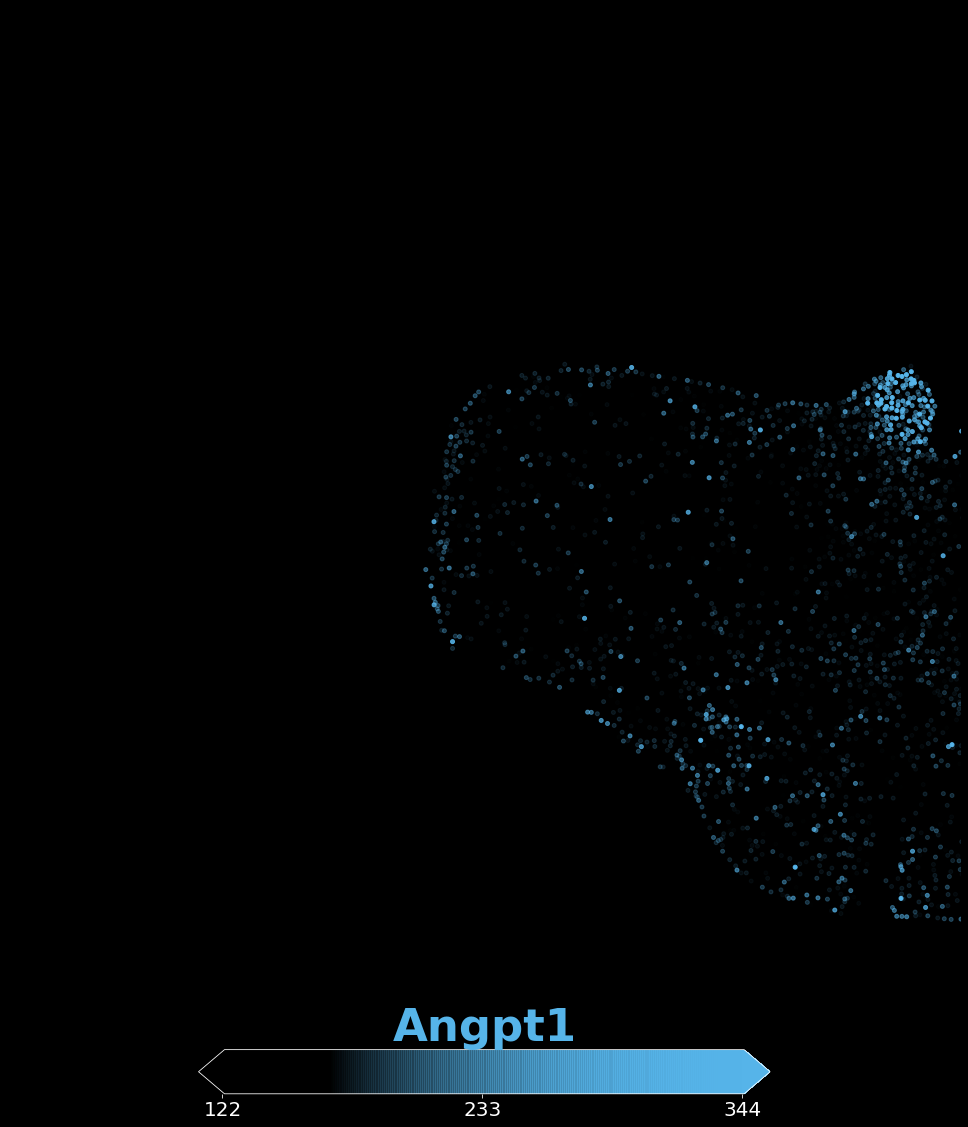

In [32]:
# Angpt1 in astros
from cell2location.plt.mapping_video import plot_spatial

with matplotlib.rc_context({'axes.facecolor':  'white',
                            "figure.figsize": [20,20]}):
    fig = plot_spatial(angpt1[['mean_intensity']], labels=['Angpt1'],
                  coords=angpt1[['centroid-1', 'centroid-0']].values * resize_factor, 
                  img=img_layer_small, show_img=True, img_alpha=0,
                  circle_diameter=4, alpha_scaling=1, reorder_cmap=[2, 0, 1],
                  plt_axis='off', style='dark_background',
                  max_color_quantile=0.99, image_cmap='Greys_r',
                  crop_x=[100, 1850], crop_y=[100, 1900], axis_y_flipped=True,
                     colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                     colorbar_shape={'vertical_gaps': 0.12, 'horizontal_gaps': 1, 
                                     'width': 3.5, 'height': 0.045},
                     colorbar_tick_size=20)

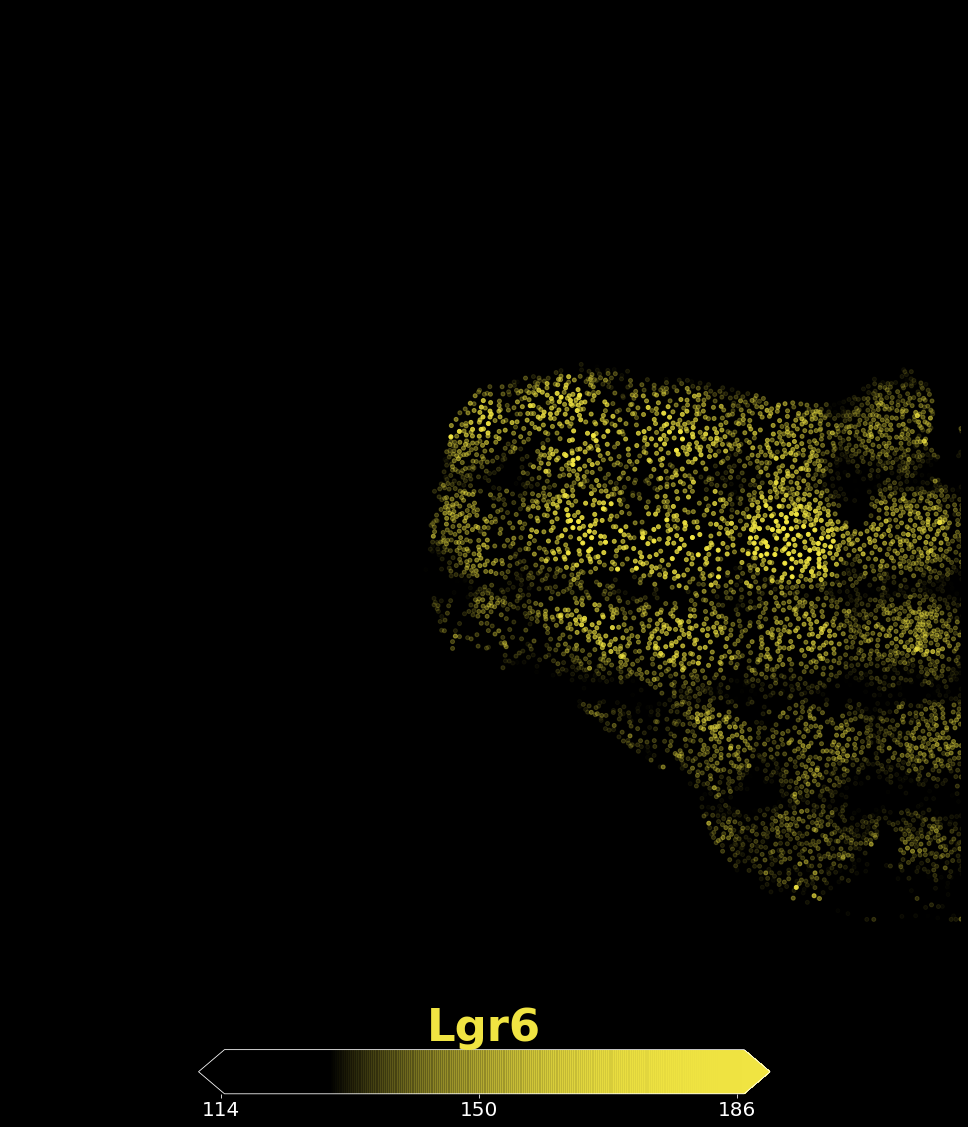

In [33]:
# Lgr6 in astros
with matplotlib.rc_context({'axes.facecolor':  'white',
                            "figure.figsize": [20,20]}):
    fig = plot_spatial(lgr6[['mean_intensity']], labels=['Lgr6'],
                  coords=lgr6[['centroid-1', 'centroid-0']].values * resize_factor, 
                  img=img_layer_small, show_img=True, img_alpha=0,
                  circle_diameter=4, alpha_scaling=1, reorder_cmap=[0, 1],
                  plt_axis='off', style='dark_background',
                  max_color_quantile=0.99, image_cmap='Greys_r',
                  crop_x=[100, 1850], crop_y=[100, 1900], axis_y_flipped=True,
                     colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                     colorbar_shape={'vertical_gaps': 0.12, 'horizontal_gaps': 1, 
                                     'width': 3.5, 'height': 0.045},
                     colorbar_tick_size=20)

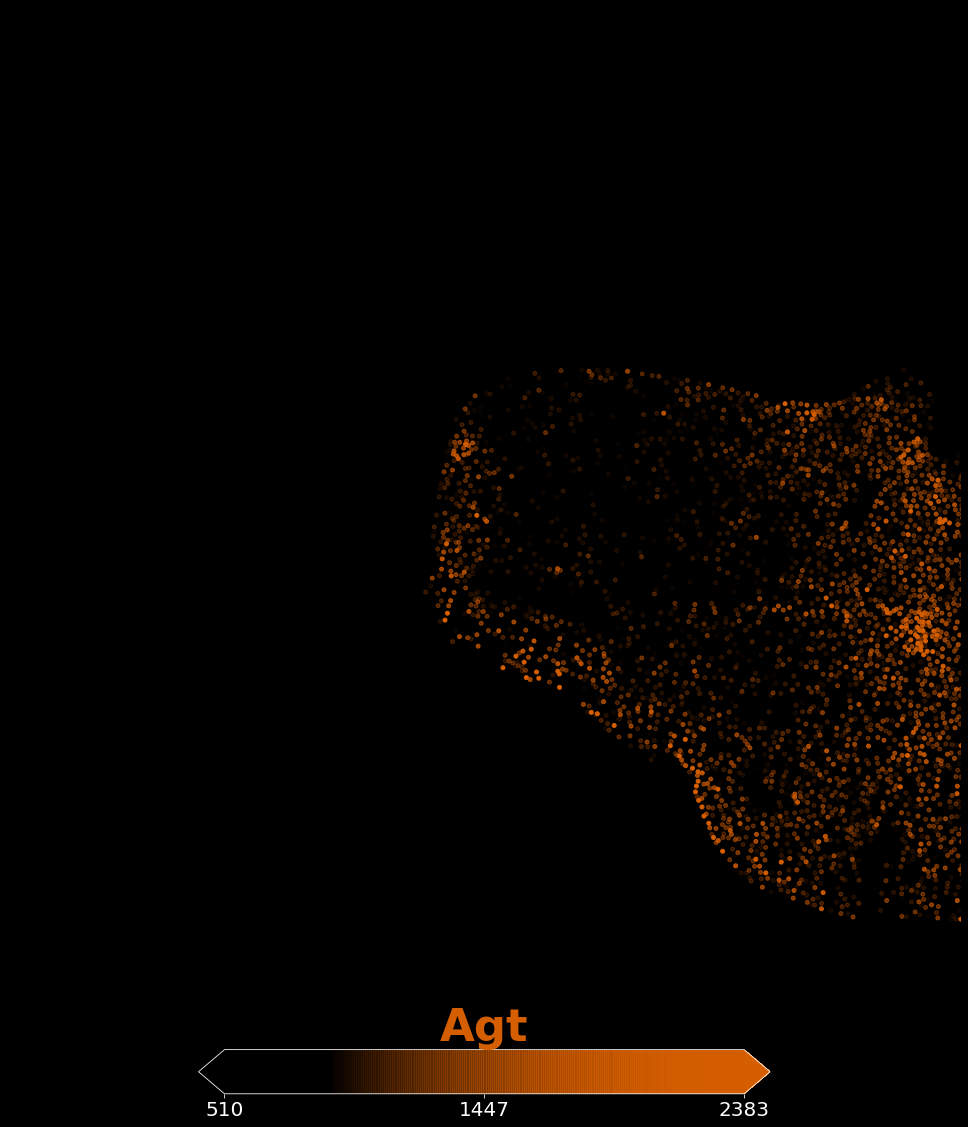

In [34]:
# Agt in astros 
with matplotlib.rc_context({'axes.facecolor':  'white',
                            "figure.figsize": [20,20]}):
    fig = plot_spatial(agt[['mean_intensity']], labels=['Agt'],
                  coords=agt[['centroid-1', 'centroid-0']].values * resize_factor, 
                  img=img_layer_small, show_img=True, img_alpha=0,
                  circle_diameter=4, alpha_scaling=1, reorder_cmap=[1],
                  plt_axis='off', style='dark_background',
                  max_color_quantile=0.99, image_cmap='Greys_r',
                  crop_x=[100, 1850], crop_y=[100, 1900], axis_y_flipped=True,
                     colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                     colorbar_shape={'vertical_gaps': 0.12, 'horizontal_gaps': 1, 
                                     'width': 3.5, 'height': 0.045},
                     colorbar_tick_size=20)

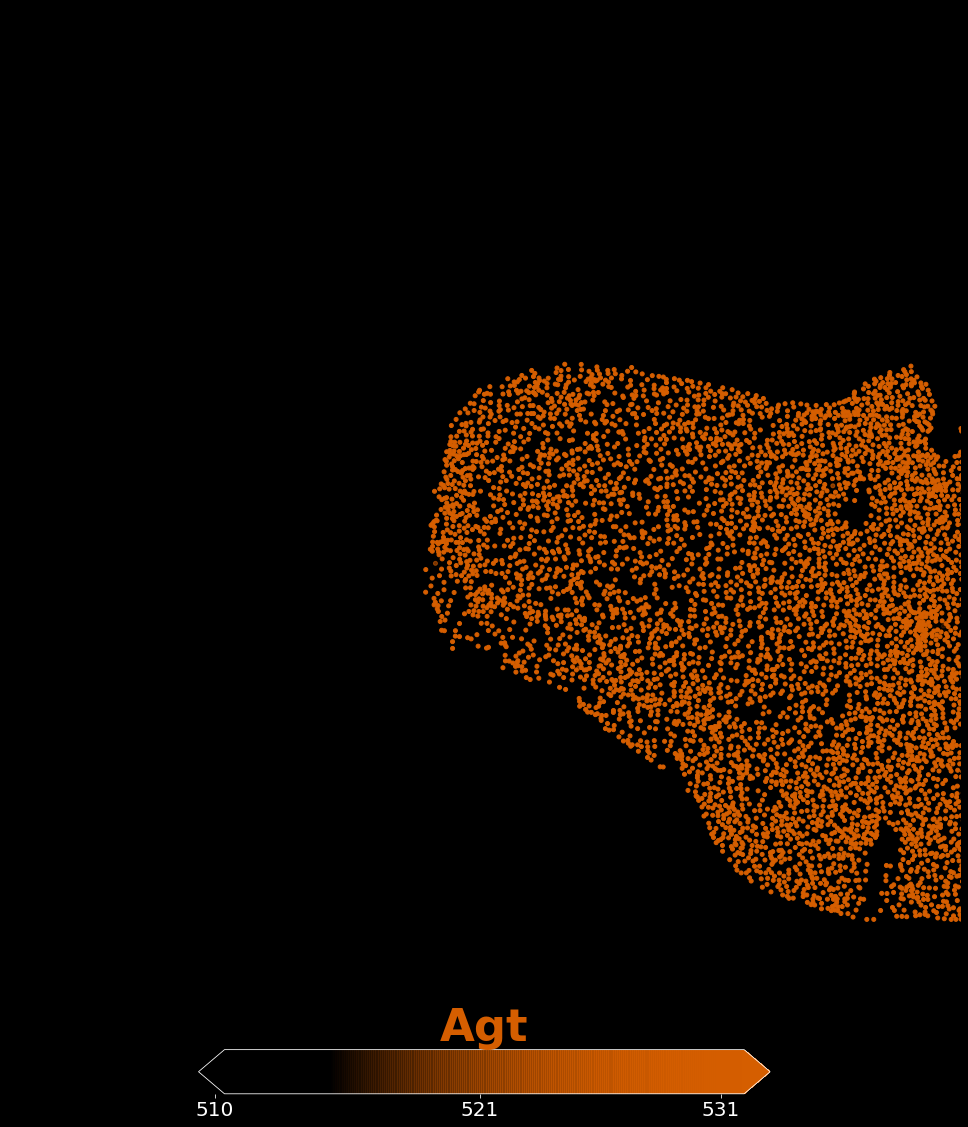

In [35]:
# Show all astros
with matplotlib.rc_context({'axes.facecolor':  'white',
                            "figure.figsize": [20,20]}):
    fig = plot_spatial(agt[['mean_intensity']], labels=['Agt'],
                  coords=agt[['centroid-1', 'centroid-0']].values * resize_factor, 
                  img=img_layer_small, show_img=True, img_alpha=0,
                  circle_diameter=4, alpha_scaling=1, reorder_cmap=[1],
                  plt_axis='off', style='dark_background',
                  max_color_quantile=0.001, image_cmap='Greys_r',
                  crop_x=[100, 1850], crop_y=[100, 1900], axis_y_flipped=True,
                     colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                     colorbar_shape={'vertical_gaps': 0.12, 'horizontal_gaps': 1, 
                                     'width': 3.5, 'height': 0.045},
                     colorbar_tick_size=20)

### Zoom-in maps with background

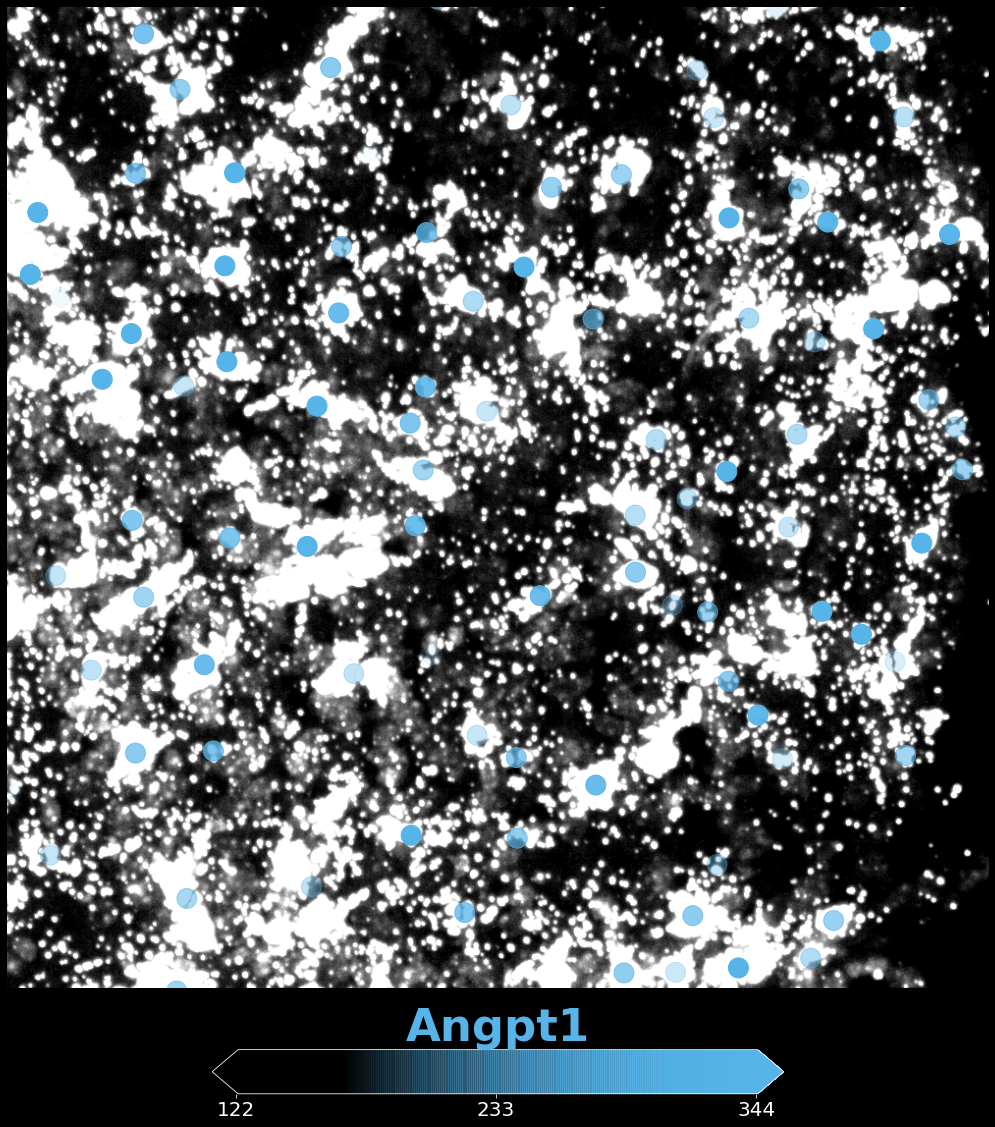

In [19]:
from cell2location.plt.mapping_video import plot_spatial

img_layer_agt = prepare_image(imgs, colored_segm_img=None, 
                                layer_num=2, alpha=0.5, 
                                resize_factor=None,
                                rescale_intensities=(150, 1000))

with matplotlib.rc_context({'axes.facecolor':  'white',
                            "figure.figsize": [20,20]}):
    fig = plot_spatial(angpt1[['mean_intensity']], labels=['Angpt1'],
                  coords=angpt1[['centroid-1', 'centroid-0']].values, 
                  img=img_layer_agt, show_img=True, img_alpha=1,
                  circle_diameter=20, alpha_scaling=1, reorder_cmap=[2, 0, 1],
                  plt_axis='off', style='dark_background',
                  max_color_quantile=0.99, image_cmap='Greys_r',
                  crop_x=[1700 / resize_factor, 1800 / resize_factor], 
                  crop_y=[800 / resize_factor, 900 / resize_factor], 
                       axis_y_flipped=True,
                     colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                     colorbar_shape={'vertical_gaps': 0.12, 'horizontal_gaps': 1, 
                                     'width': 3.5, 'height': 0.045},
                     colorbar_tick_size=20)

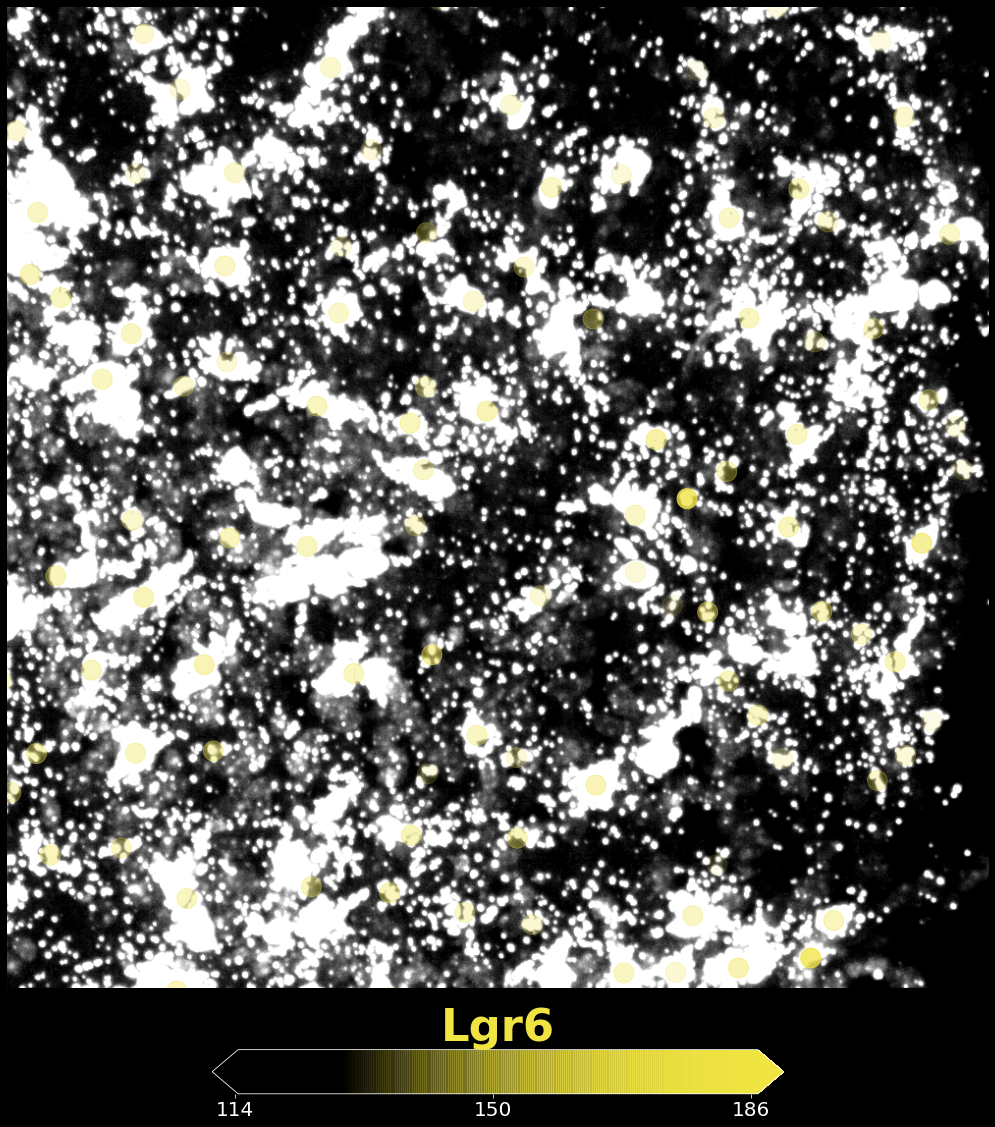

In [20]:
from cell2location.plt.mapping_video import plot_spatial

with matplotlib.rc_context({'axes.facecolor':  'white',
                            "figure.figsize": [20,20]}):
    fig = plot_spatial(lgr6[['mean_intensity']], labels=['Lgr6'],
                  coords=lgr6[['centroid-1', 'centroid-0']].values, 
                  img=img_layer_agt, show_img=True, img_alpha=1,
                  circle_diameter=20, alpha_scaling=1, reorder_cmap=[0, 1],
                  plt_axis='off', style='dark_background',
                  max_color_quantile=0.99, image_cmap='Greys_r',
                  crop_x=[1700 / resize_factor, 1800 / resize_factor], 
                  crop_y=[800 / resize_factor, 900 / resize_factor], 
                       axis_y_flipped=True,
                     colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                     colorbar_shape={'vertical_gaps': 0.12, 'horizontal_gaps': 1, 
                                     'width': 3.5, 'height': 0.045},
                     colorbar_tick_size=20)

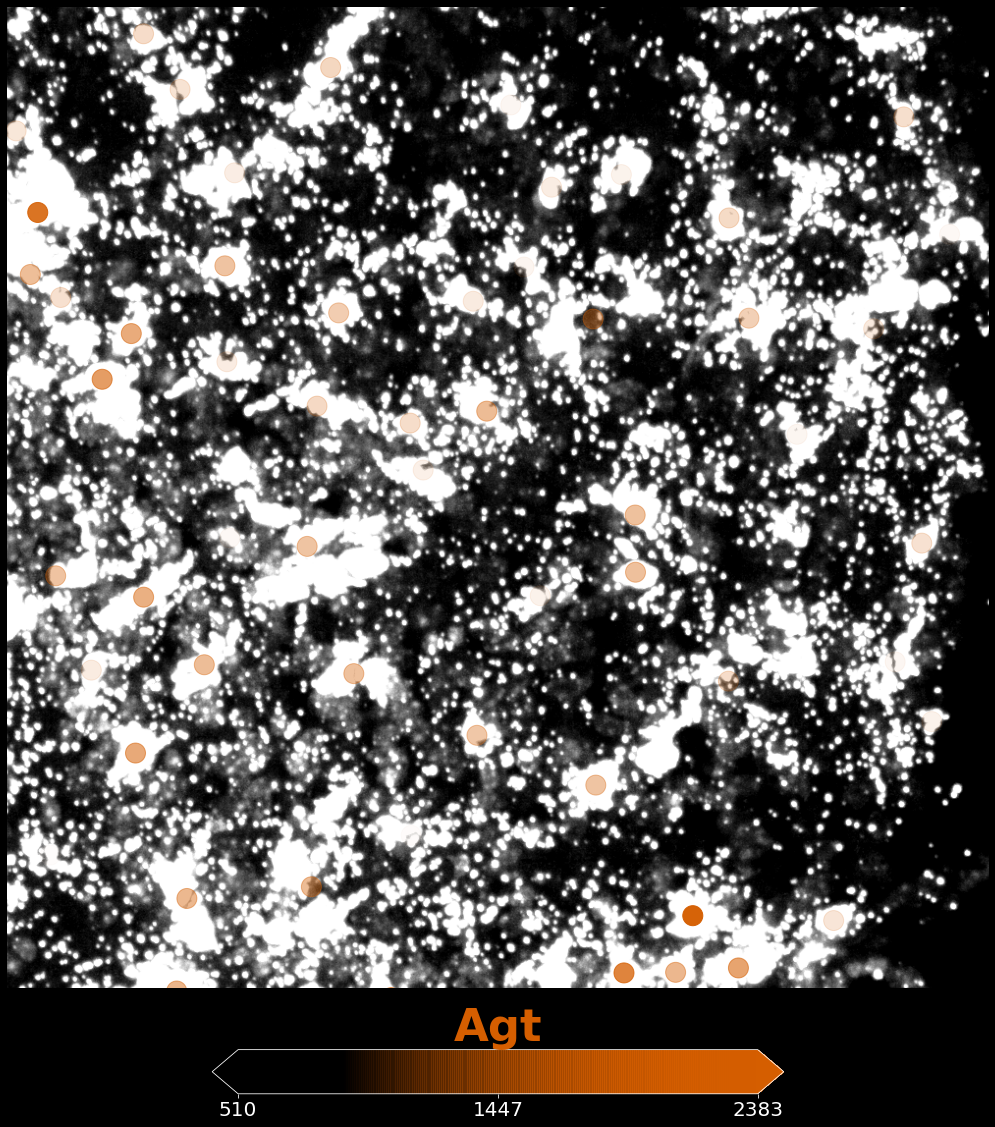

In [21]:
from cell2location.plt.mapping_video import plot_spatial

with matplotlib.rc_context({'axes.facecolor':  'white',
                            "figure.figsize": [20,20]}):
    fig = plot_spatial(agt[['mean_intensity']], labels=['Agt'],
                  coords=agt[['centroid-1', 'centroid-0']].values, 
                  img=img_layer_agt, show_img=True, img_alpha=1,
                  circle_diameter=20, alpha_scaling=1, reorder_cmap=[1],
                  plt_axis='off', style='dark_background',
                  max_color_quantile=0.99, image_cmap='Greys_r',
                  crop_x=[1700 / resize_factor, 1800 / resize_factor], 
                  crop_y=[800 / resize_factor, 900 / resize_factor], 
                       axis_y_flipped=True,
                     colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                     colorbar_shape={'vertical_gaps': 0.12, 'horizontal_gaps': 1, 
                                     'width': 3.5, 'height': 0.045},
                     colorbar_tick_size=20)

### Zoom-in with segmentation mask

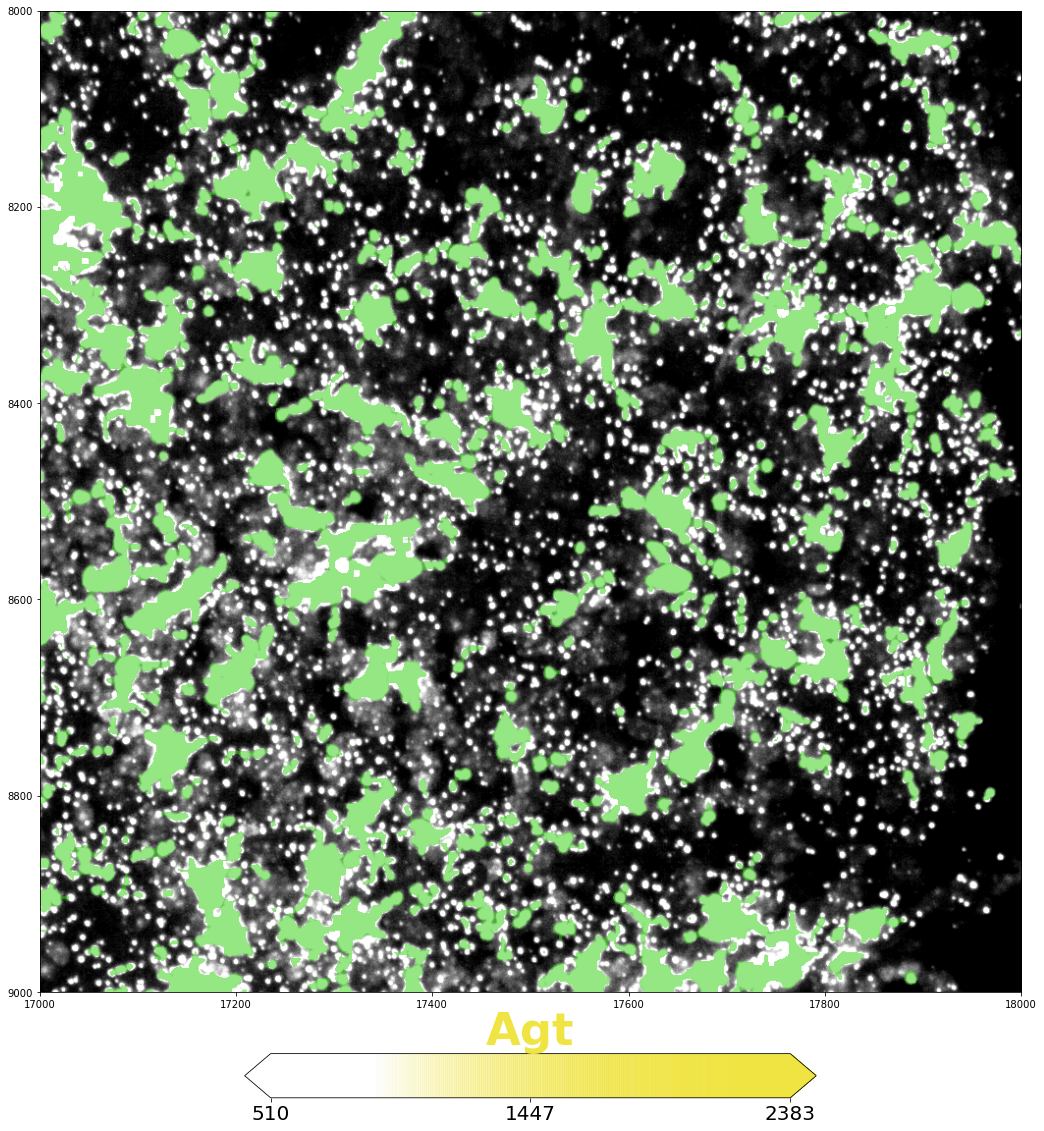

In [22]:
from cell2location.plt.mapping_video import plot_spatial

img_layer_agt = prepare_image(imgs, colored_segm_img=colored_segm_img, 
                                layer_num=2, alpha=0.5, 
                                resize_factor=None,
                                rescale_intensities=(150, 1000))

#from PIL import Image
#Image.fromarray(img_layer_agt.astype(np.uint8)).save(
#    f'{my_masks_path}{slide_id}.ome_cyto_diam_35_assembled_selected_overlay.png'
#)

with matplotlib.rc_context({'axes.facecolor':  'white',
                            "figure.figsize": [20,20]}):
    fig = plot_spatial(agt[['mean_intensity']], labels=['Agt'],
                  coords=agt[['centroid-1', 'centroid-0']].values, 
                  img=img_layer_agt, show_img=True, img_alpha=1,
                  circle_diameter=20, alpha_scaling=0, reorder_cmap=[0, 1],
                       plt_axis='on',
                  max_color_quantile=0.99, image_cmap='Greys_r',
                  crop_x=[1700 / resize_factor, 1800 / resize_factor], 
                  crop_y=[800 / resize_factor, 900 / resize_factor], 
                       axis_y_flipped=True,
                     colorbar_label_kw={'size': 45, 'weight': 'bold', 'y': 1.29},
                     colorbar_shape={'vertical_gaps': 0.12, 'horizontal_gaps': 1, 
                                     'width': 3.5, 'height': 0.045},
                     colorbar_tick_size=20)